In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

# Define the ticker symbol for TCS
ticker_symbol = "TCS.NS" # .NS for National Stock Exchange (India)

# Calculate the end date (today) and start date (5 years ago)
end_date = datetime.now()
start_date = end_date - timedelta(days=5 * 365) # Approximate 5 years

# Download the stock data
tcs_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first 5 rows of the downloaded data
print(f"Downloaded {len(tcs_data)} rows of data for {ticker_symbol} from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}.")
print(tcs_data.head())

/tmp/ipython-input-2876525551.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tcs_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 1237 rows of data for TCS.NS from 2020-12-22 to 2025-12-21.
Price             Close         High          Low         Open   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2020-12-22  2566.169434  2576.130283  2518.062045  2531.775170  2881737
2020-12-23  2598.554443  2607.711361  2559.872008  2569.341688  2790988
2020-12-24  2599.089844  2609.810134  2575.728413  2598.777081  1807144
2020-12-28  2617.001465  2635.136666  2592.523556  2599.670416  2108994
2020-12-29  2617.984619  2637.191809  2608.604364  2608.604364  1994151


In [ ]:
tcs_data = tcs_data.reset_index()

# Define the desired new column names
new_columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Assign the new column names directly
tcs_data.columns = new_columns

# Display the first few rows of the cleaned data
print("DataFrame with cleaned columns:")
print(tcs_data.head())

DataFrame with cleaned columns:
        Date        Close         High          Low         Open   Volume
0 2020-12-22  2566.169434  2576.130283  2518.062045  2531.775170  2881737
1 2020-12-23  2598.554443  2607.711361  2559.872008  2569.341688  2790988
2 2020-12-24  2599.089844  2609.810134  2575.728413  2598.777081  1807144
3 2020-12-28  2617.001465  2635.136666  2592.523556  2599.670416  2108994
4 2020-12-29  2617.984619  2637.191809  2608.604364  2608.604364  1994151


In [ ]:
!pip install pmdarima arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 15.3 MB/s eta 0:00:00


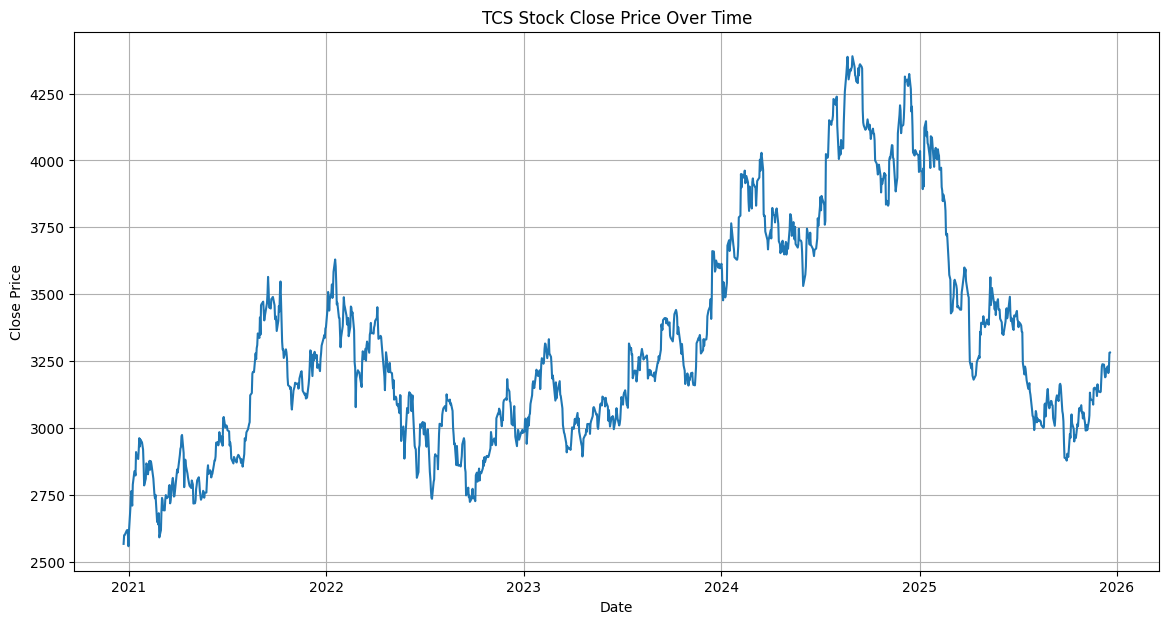

In [ ]:
# Ensure 'Date' column is in datetime format
tcs_data['Date'] = pd.to_datetime(tcs_data['Date'])

plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=tcs_data)
plt.title('TCS Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

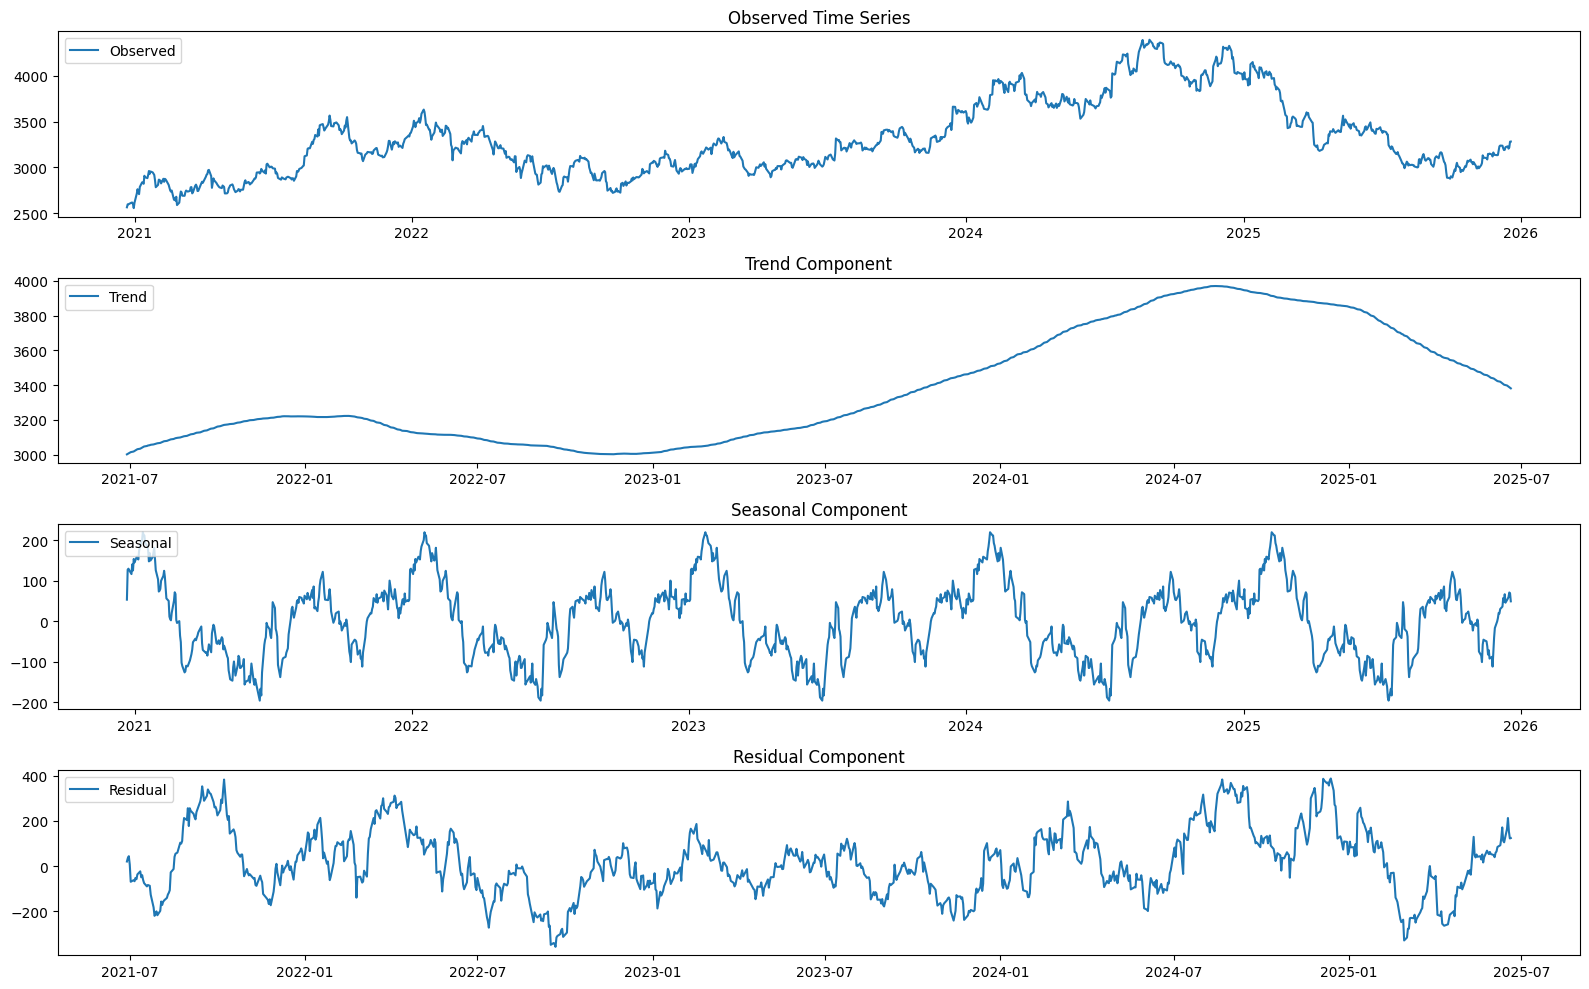

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set 'Date' as index for time series decomposition
tcs_data_indexed = tcs_data.set_index('Date')

# Perform additive decomposition on the 'Close' price
# A period of 252 is chosen, representing approximately the number of trading days in a year
decomposition = seasonal_decompose(tcs_data_indexed['Close'], model='additive', period=252)

# Plot the decomposed components
plt.figure(figsize=(16, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.title('Observed Time Series')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the 'Close' price column
result = adfuller(tcs_data['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("Conclusion: The 'Close' price series is likely stationary (reject H0).")
elif result[0] < result[4]['5%']:
    print("Conclusion: The 'Close' price series is likely stationary (reject H0).")
else:
    print("Conclusion: The 'Close' price series is likely non-stationary (fail to reject H0).")

ADF Statistic: -2.315314
p-value: 0.167077
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Conclusion: The 'Close' price series is likely non-stationary (fail to reject H0).


difference data to bring it to stationary

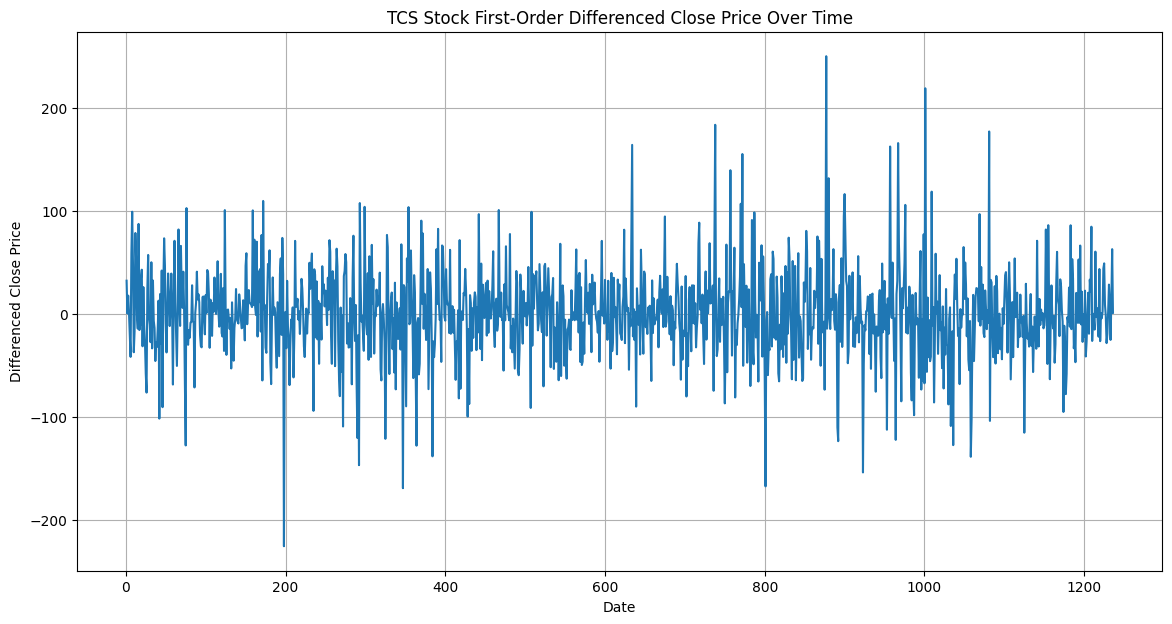


ADF Test Results for Differenced Series:
ADF Statistic: -34.107966
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Conclusion: The differenced 'Close' price series is likely stationary (reject H0).


In [ ]:
# Create the 'Close_Diff' column in the DataFrame. This will introduce a NaN at the first row.
tcs_data['Close_Diff'] = tcs_data['Close'].diff()

# For ADF test and plotting, we need a series without NaN values.
# We will use the 'Close_Diff' column and drop its NaN values for these operations.
differenced_series_for_analysis = tcs_data['Close_Diff'].dropna()

plt.figure(figsize=(14, 7))
# Align dates for plotting: the differenced series starts from the second date.
# We use the index of the differenced series itself for plotting, which will be correctly aligned.
sns.lineplot(x=differenced_series_for_analysis.index, y=differenced_series_for_analysis)
plt.title('TCS Stock First-Order Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.grid(True)
plt.show()

# Perform ADF test on the clean differenced series
result_diff = adfuller(differenced_series_for_analysis)

# Print the results
print('\nADF Test Results for Differenced Series:')
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result_diff[1] <= 0.05:
    print("Conclusion: The differenced 'Close' price series is likely stationary (reject H0).")
elif result_diff[0] < result_diff[4]['5%']:
    print("Conclusion: The differenced 'Close' price series is likely stationary (reject H0).")
else:
    print("Conclusion: The differenced 'Close' price series is likely non-stationary (fail to reject H0).")

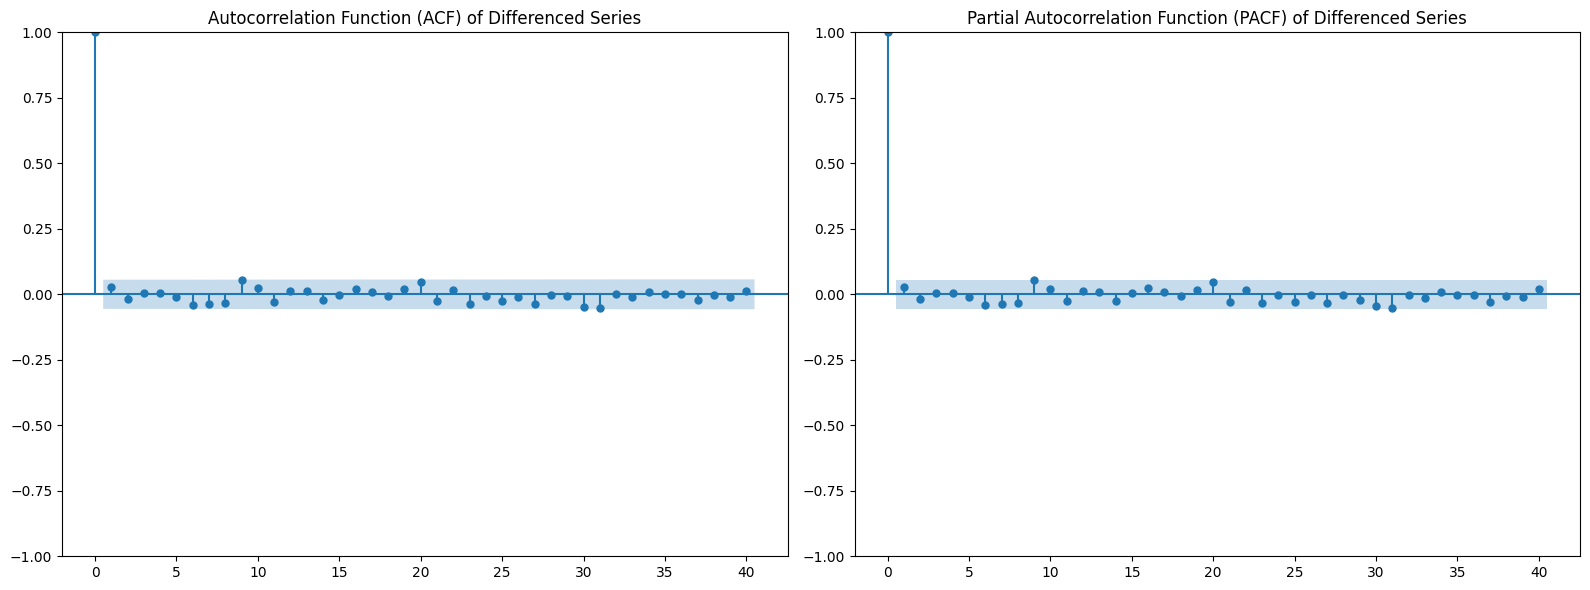

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(differenced_series_for_analysis, ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF) of Differenced Series')

plot_pacf(differenced_series_for_analysis, ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

run auto arima as we are unable to find the lags

In [ ]:
import pmdarima as pm

# Fit auto_arima to the 'Close' price series
# d=1 since we've already determined first-order differencing makes the series stationary
# seasonal=False as we are primarily looking at daily data without obvious yearly seasonality in this context
# stepwise=True for faster execution by performing a stepwise search
# suppress_warnings=True to avoid convergence warnings
model = pm.auto_arima(tcs_data['Close'],
                      d=1,           # integrated order, as determined by ADF test after 1st diff
                      start_p=0,     # initial guess for p
                      start_q=0,     # initial guess for q
                      max_p=5,       # max p to search
                      max_q=5,       # max q to search
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      trace=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12845.322, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12846.258, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12846.219, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12843.540, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12847.826, Time=3.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.752 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1237
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6420.770
Date:                Sun, 21 Dec 2025   AIC                          12843.540
Time:                        07:17:51   BIC                          12848.659
Sample:                             0   HQIC                         12845.465
                               - 1237                                  

data has white noise, perform ARCH & GARCH

In [ ]:
# Get the residuals from the ARIMA model
arima_residuals = model.resid()

# Import arch for ARCH/GARCH modeling
from arch import arch_model

# Fit an ARCH(1) model to the residuals
# p=1 for ARCH(1)
# vol='ARCH' explicitly states we want an ARCH model
arch_model_fit = arch_model(arima_residuals, vol='ARCH', p=1, q=0).fit(disp='off')

# Print the ARCH model summary
print(arch_model_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6473.13
Distribution:                  Normal   AIC:                           12952.3
Method:            Maximum Likelihood   BIC:                           12967.6
                                        No. Observations:                 1237
Date:                Sun, Dec 21 2025   Df Residuals:                     1236
Time:                        07:29:33   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4713      1.256      0.375      0.708 [ -1.991,  2.93

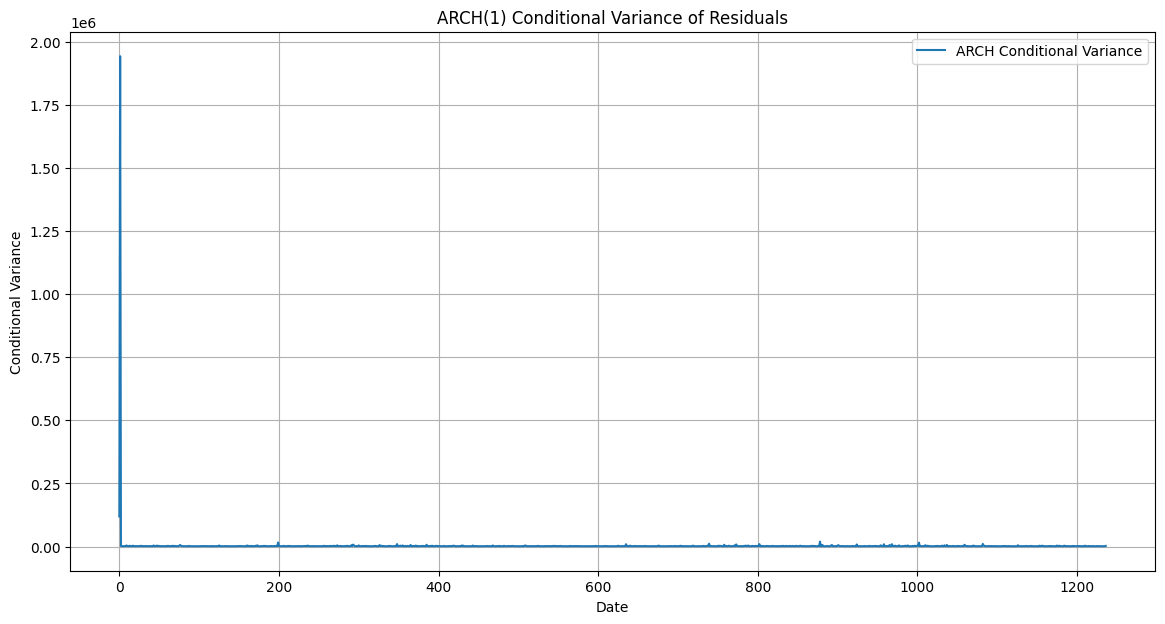

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(arch_model_fit.conditional_volatility**2, label='ARCH Conditional Variance')
plt.title('ARCH(1) Conditional Variance of Residuals')
plt.xlabel('Date')
plt.ylabel('Conditional Variance')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Fit a GARCH(1,1) model to the residuals
# p=1 for ARCH terms, q=1 for GARCH terms
garch_model_fit = arch_model(arima_residuals, vol='Garch', p=1, q=1).fit(disp='off')

# Print the GARCH model summary
print(garch_model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6448.40
Distribution:                  Normal   AIC:                           12904.8
Method:            Maximum Likelihood   BIC:                           12925.3
                                        No. Observations:                 1237
Date:                Sun, Dec 21 2025   Df Residuals:                     1236
Time:                        07:32:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5950      1.277      0.466      0.641 [ -1.907,  3.09

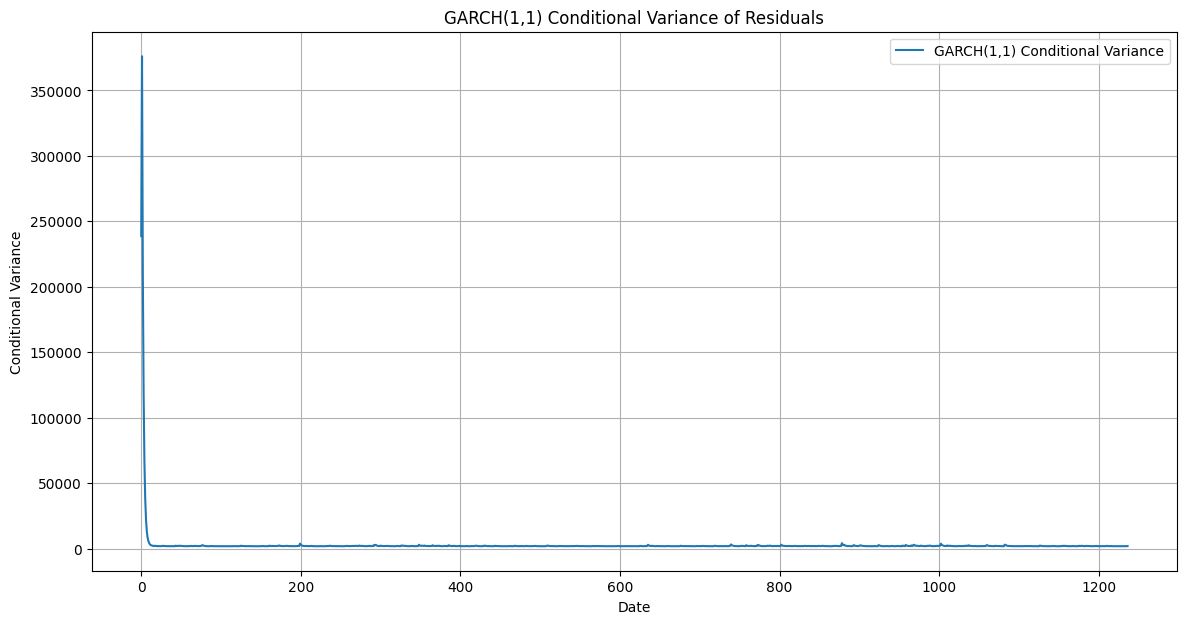

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(garch_model_fit.conditional_volatility**2, label='GARCH(1,1) Conditional Variance')
plt.title('GARCH(1,1) Conditional Variance of Residuals')
plt.xlabel('Date')
plt.ylabel('Conditional Variance')
plt.grid(True)
plt.legend()
plt.show()